# Stochastic Epigenetic Dynamics of Gene Switching

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numba import guvectorize, vectorize, float64, int64, jit

### Parameters init

In [3]:
omega = 100
w_p = 0
w_xi = 0
w_z = 0
c = 20


k = 1             #k is 2days^-1 ~ 6e-6 s^-1
f = 0.1*k
h0 = 2*k
g_m1m1 = 0     *k
g_m10 = 0      *k
g_m11 = 0.2    *k
g_1m1 = 0      *k
g_10 = 0.2     *k
g_11 = 1.0     *k
r_10 = 1.      *k
r_01 = 1.      *k
r_0m1 = 1.     *k
r_m10 = 1.     *k
dr_10 = 1.     *k
dr_01 = 0      *k
dr_0m1 = 1.    *k
dr_m10 = 0     *k

## Langevin Equations simulation

In [26]:
steps = 10000
p = np.zeros(steps)
xi = np.zeros(steps)
z = np.zeros(steps)
N = 100
mean_p = np.zeros(steps)
mean_xi = np.zeros(steps)
mean_z = np.zeros(steps)

p[0] = 0.75
xi[0] = 0.8
z[0] = 0.8
dt = 1e-3     # ~ 160 s
for j in range(N):
    for i in range(steps-1):
        theta = np.arccos(xi[i])
        alpha = np.arccos(z[i])
        
        z_c = np.cos(alpha/2)**2
        z_s = np.sin(alpha/2)**2
        xi_c = np.cos(theta/2)**2
        xi_s = np.sin(theta/2)**2
        fp = (xi_c*(g_11*z_c**2 + 2*g_10*z_c*z_s + g_1m1*z_s**2) +
              xi_s*(g_m11*z_c**2 + 2*g_m10*z_c*z_s + g_m1m1*z_s**2))
        fs = 2*(r_10 + xi_c*dr_10)*z_c*z_s + (r_0m1 + xi_c*dr_0m1)*z_s**2
        fc = 2*(r_m10 + xi_c*dr_m10)*z_c*z_s + (r_01 + xi_c*dr_01)*z_c**2
        eta_p = np.random.randn()*np.sqrt((fp+k*p[i])/omega)
        eta_xi = np.random.randn()*np.sqrt((4*h0*p[i]**2*xi_s + 4*f*xi_c))
        eta_z = np.random.randn()*np.sqrt((fs + fc))
        
        if (p[i] <= 0.1):
            w_p = -c*(p[i]-0.1)**3
        else:
            w_p = 0
        if (xi[i] <= -0.9):
            w_xi = -c*(xi[i]+0.9)**3
        elif (xi[i] >= 0.9):
            w_xi = -c*(xi[i]-0.9)**3
        else:
            w_xi = 0
        if (z[i] <= -0.9):
            w_z = -c*(z[i]+0.9)**3
        elif (z[i] >= 0.9):
            w_z = -c*(z[i]-0.9)**3
        else:
            w_z = 0
            
        p[i+1] = p[i] + (fp - k*p[i] + w_p + eta_p)*dt
        xi[i+1] = xi[i] + (2*h0*p[i]**2*xi_s - 2*f*xi_c + w_xi + eta_xi)*dt
        z[i+1] = z[i] + (fs - fc + w_z + eta_z)*dt
        
        if (z[i+1]< -1):
            z[i+1] = -1
        elif (z[i+1] > 1):
            z[i+1] = 1
        if (xi[i+1]< -1):
            xi[i+1] = -1
        elif (xi[i+1] > 1):
            xi[i+1] = 1
    mean_p = mean_p + p
    mean_z = mean_z + z
    mean_xi = mean_xi + xi

    
mean_p = mean_p/N 
mean_z = mean_z/N
mean_xi = mean_xi/N 

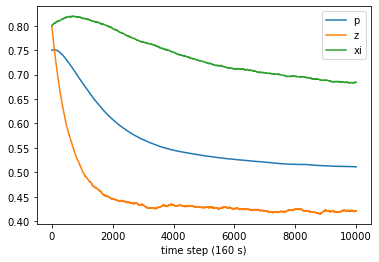

In [29]:
plt.plot(range(steps),mean_p,label='p')
plt.plot(range(steps),mean_z,label='z')
plt.plot(range(steps),mean_xi,label='xi')
plt.legend()
plt.xlabel('time step (160 s)')
plt.show()

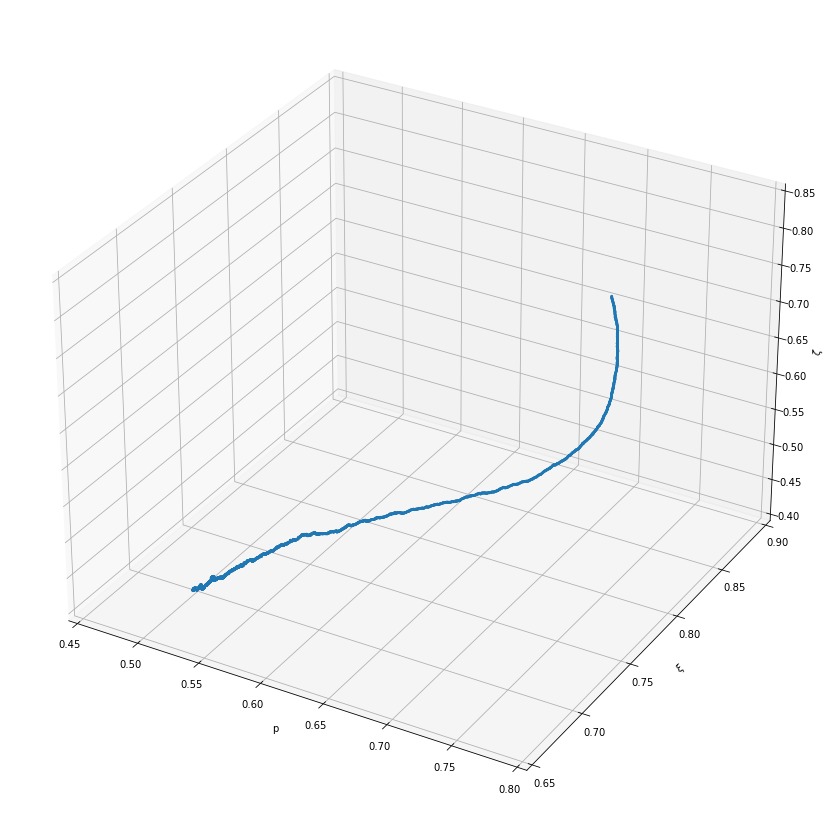

In [45]:
ax = plt.figure(figsize=(20,15)).add_subplot(projection='3d')
ax.scatter(mean_p, mean_xi, mean_z, s=3)
ax.set(xlim=(0.45,0.8), ylim=(0.65,0.9), zlim=(0.4,0.85))
ax.set(xlabel=r'p',ylabel=r'$\xi$',zlabel=r'$\zeta$')
plt.show()

## Landscape numerical estimate through simulation

The landscape potential is given by $U=-\log \rho_{ss}$ where $\rho_{ss}$ is the stationary probability distribution solving the Fokker-Planck equation, $\nabla\cdot J(\rho)=\partial_t\rho_{ss}=0$. So the equation to be solved numerically to obtain the probability distribution is of the form:

$$
a_p\frac{\partial^2 \rho}{\partial p^2} + b_p\frac{\partial \rho}{\partial p} +
a_\chi\frac{\partial^2 \rho}{\partial \chi^2} + b_\chi\frac{\partial \rho}{\partial \chi} +
a_\zeta\frac{\partial^2 \rho}{\partial \zeta^2} + b_\zeta\frac{\partial \rho}{\partial \zeta} +
c\rho = 0
$$

In [3]:
@jit
def variation(f_dp,f__dp,f_dxi,f__dxi,f_dz,f__dz,ff,
              p,xi,z#,var
             ):
    
    Np = 100
    Nxi = 100
    Nz = 100
    Lp = 1.5 # p in [0,1.5]
    Lxi = 2 # xi in [-1,1]
    Lz = 2 # z in [-1,1]
    dp = Lp/Np
    dxi = Lxi/Nxi
    dz = Lz/Nz
    
    omega = 100
    k = 1
    f = 0.1*k
    h0 = 2*k
    g_m1m1 = 0     *k
    g_m10 = 0      *k
    g_m11 = 0.2    *k
    g_1m1 = 0      *k
    g_10 = 0.2     *k
    g_11 = 1.0     *k
    r_10 = 1.      *k
    r_01 = 1.      *k
    r_0m1 = 1.     *k
    r_m10 = 1.     *k
    dr_10 = 1.     *k
    dr_01 = 0      *k
    dr_0m1 = 1.    *k
    dr_m10 = 0     *k
    
    xi_c = (1+xi)/2
    xi_s = (1-xi)/2
    z_c = (1+z)/2
    z_s = (1-z)/2

    fp = (xi_c*(g_11*z_c**2 + 2*g_10*z_c*z_s + g_1m1*z_s**2) +
          xi_s*(g_m11*z_c**2 + 2*g_m10*z_c*z_s + g_m1m1*z_s**2))
    r_10 = r_10 + xi_c*dr_10
    r_0m1 = r_0m1 + xi_c*dr_0m1
    r_m10 = r_m10 + xi_c*dr_m10
    r_01 = r_01 + xi_c*dr_01
    
    ap = (k*p+fp)/2/omega
    bp = k*p -fp + k/omega
    axi = f*(1+xi)+h0*p**2*(1-xi)
    bxi = f*(3+xi)-h0*p**2*(3-xi)
    az = (r_01*(1+z)**2 + 2*(r_10+r_m10)*(1-z**2) + r_0m1*(1-z)**2)/8
    bz = (r_01*(1+z)**2/4 - (r_10-r_m10)*(1-z**2)/2 - r_0m1*(1-z)**2/4 +
          r_01*(1+z)/2 - z*(r_10+r_m10) - r_0m1*(1-z)/2)
    c = k + f + h0*p**2 + r_0m1*(3-2*z)/4 + z*(r_10-r_m10) - (r_10+r_m10)/2 + r_01*(3+2*z)/4
    
    var = (ap*(f_dp+f__dp-2*ff)/dp**2 + bp*(f_dp-f__dp)/dp/2
           + axi*(f_dxi+f__dxi-2*ff)/dxi**2 + bxi*(f_dxi-f__dxi)/dxi/2
           + az*(f_dz+f__dz-2*ff)/dz**2 + bz*(f_dz-f__dz)/dz/2
           + c*ff
          )
    return var


In [4]:
"""
@jit
def boundary(ff,p,xi,z):
    
    Np = 100
    Nxi = 100
    Nz = 100
    Lp = 1.5 # p in [0,1.5]
    Lxi = 2 # xi in [-1,1]
    Lz = 2 # z in [-1,1]
    dp = Lp/Np
    dxi = Lxi/Nxi
    dz = Lz/Nz
    
    omega = 100
    k = 1
    f = 0.1*k
    h0 = 2*k
    g_m1m1 = 0     *k
    g_m10 = 0      *k
    g_m11 = 0.2    *k
    g_1m1 = 0      *k
    g_10 = 0.2     *k
    g_11 = 1.0     *k
    r_10 = 1.      *k
    r_01 = 1.      *k
    r_0m1 = 1.     *k
    r_m10 = 1.     *k
    dr_10 = 1.     *k
    dr_01 = 0      *k
    dr_0m1 = 1.    *k
    dr_m10 = 0     *k
    
    xi_c = (1+xi[1])/2
    xi_s = (1-xi[1])/2
    z_c = (1+z[1])/2
    z_s = (1-z[1])/2
    fp = (xi_c*(g_11*z_c**2 + 2*g_10*z_c*z_s + g_1m1*z_s**2) +
          xi_s*(g_m11*z_c**2 + 2*g_m10*z_c*z_s + g_m1m1*z_s**2))
    
    a = k*p[1]-fp+k/2/omega
    a1 = (k*p[1]+fp)/2/omega
    t1 = ff[1]*(1-dp*a/a1)      #p=1.5 bound
    
    xi_c = (1+xi[0])/2
    xi_s = (1-xi[0])/2
    z_c = (1+z[0])/2
    z_s = (1-z[0])/2
    fp = (xi_c*(g_11*z_c**2 + 2*g_10*z_c*z_s + g_1m1*z_s**2) +
          xi_s*(g_m11*z_c**2 + 2*g_m10*z_c*z_s + g_m1m1*z_s**2))
    
    a = k*p[0]-fp+k/2/omega
    a1 = (k*p[0]+fp)/2/omega
    t0 = ff[0]*(1+dp*a/a1)      #p=0 bound

    a = f*(2+xi[3])-h0*p[3]**2*(2-xi[3])
    a1 = f*(1+xi[3])+h0*p[3]**2*(1-xi[3])
    t3 = ff[3]*(1-dxi*a/a1)
    a = f*(2+xi[2])-h0*p[2]**2*(2-xi[2])
    a1 = f*(1+xi[2])+h0*p[2]**2*(1-xi[2])
    t2 = ff[2]*(1+dxi*a/a1)
    
    xi_c = (1+xi[5])/2
    xi_s = (1-xi[5])/2
    z_c = (1+z[5])/2
    z_s = (1-z[5])/2
    r_10 = r_10 + xi_c*dr_10
    r_0m1 = r_0m1 + xi_c*dr_0m1
    r_m10 = r_m10 + xi_c*dr_m10
    r_01 = r_01 + xi_c*dr_01
    
    a = (r_01*(1+z[5])**2/4 - (r_10-r_m10)*(1-z[5]**2)/2 - r_0m1*(1-z[5])**2/4 +
         r_01*(1+z[5])/2 - z[5]*(r_10+r_m10) - r_0m1*(1-z[5])/2)
    a1 = (r_01*(1+z[5])**2 + 2*(r_10+r_m10)*(1-z[5]**2) + r_0m1*(1-z[5])**2)/8
    t5 = ff[5]*(1-dz*a/a1)
    
    xi_c = (1+xi[4])/2
    xi_s = (1-xi[4])/2
    z_c = (1+z[4])/2
    z_s = (1-z[4])/2
    r_10 = r_10 + xi_c*dr_10
    r_0m1 = r_0m1 + xi_c*dr_0m1
    r_m10 = r_m10 + xi_c*dr_m10
    r_01 = r_01 + xi_c*dr_01
    
    a = (r_01*(1+z[4])**2/4 - (r_10-r_m10)*(1-z[4]**2)/2 - r_0m1*(1-z[4])**2/4 +
         r_01*(1+z[4])/2 - z[4]*(r_10+r_m10) - r_0m1*(1-z[4])/2)
    a1 = (r_01*(1+z[4])**2 + 2*(r_10+r_m10)*(1-z[4]**2) + r_0m1*(1-z[4])**2)/8
    t4 = ff[4]*(1+dz*a/a1)
    
    bound = [t0,t1,t2,t3,t4,t5]
    return bound
"""

In [4]:
Np = 100
Nxi = 100
Nz = 100
Lp = 1.5 # p in [0,1.5]
Lxi = 2 # xi in [-1,1]
Lz = 2 # z in [-1,1]
dp = Lp/Np
dxi = Lxi/Nxi
dz = Lz/Nz

omega = 100

rho = np.ones((Np,Nxi,Nz))
(rho[0,:,:],rho[Np-1,:,:],rho[:,0,:],rho[:,Nxi-1,:],rho[:,:,0],rho[:,:,Nz-1])=(0,0,0,0,0,0)
(rho[1,:,:],rho[Np-2,:,:],rho[:,1,:],rho[:,Nxi-2,:],rho[:,:,1],rho[:,:,Nz-2])=(0,0,0,0,0,0)

p = np.array([[[dp*i for k in range(Nz)] for j in range(Nxi)] for i in range(Np)])
xi = np.array([[[-1+dxi*j for k in range(Nz)] for j in range(Nxi)] for i in range(Np)])
z = np.array([[[-1+dz*k for k in range(Nz)] for j in range(Nxi)] for i in range(Np)])

integral = dp*dxi*dz * rho.sum()
rho = rho/integral

p_ = p[1:Np-1,1:Nxi-1,1:Nz-1]
xi_ = xi[1:Np-1,1:Nxi-1,1:Nz-1]
z_ = z[1:Np-1,1:Nxi-1,1:Nz-1]
P = (p[1,:,:],
     p[Np-2,:,:],
     p[:,1,:],
     p[:,Nxi-2,:],
     p[:,:,1],
     p[:,:,Nz-2])
XI = (xi[1,:,:],
      xi[Np-2,:,:],
      xi[:,1,:],
      xi[:,Nxi-2,:],
      xi[:,:,1],
      xi[:,:,Nz-2])
Z = (z[1,:,:],
     z[Np-2,:,:],
     z[:,1,:],
     z[:,Nxi-2,:],
     z[:,:,1],
     z[:,:,Nz-2])


dt = 1e-7
evol = np.ones((Np-2,Nxi-2,Nz-2))
count = 0
while np.abs(evol).max() > 1e-1:
    rho_dt = np.zeros((Np,Nxi,Nz))
    
    #f_faces = (rho[1,:,:],
    #           rho[Np-2,:,:],
    #           rho[:,1,:],
    #           rho[:,Nxi-2,:],
    #           rho[:,:,1],
    #           rho[:,:,Nz-2])
    #(rho[0,:,:],
    # rho[Np-1,:,:],
    # rho[:,0,:],
    # rho[:,Nxi-1,:],
    # rho[:,:,0],
    # rho[:,:,Nz-1]) = boundary(f_faces,P,XI,Z)
    rho_dt[0,:,:] = rho[0,:,:]
    rho_dt[Np-1,:,:] = rho[Np-1,:,:]
    rho_dt[:,0,:] = rho[:,0,:]
    rho_dt[:,Nxi-1,:] = rho[:,Nxi-1,:]
    rho_dt[:,:,0] = rho[:,:,0]
    rho_dt[:,:,Nz-1] = rho[:,:,Nz-1]
    
    f_dp_ = rho[2:Np,1:Nxi-1,1:Nz-1]
    f__dp_ = rho[:Np-2,1:Nxi-1,1:Nz-1]
    f_dxi_ = rho[1:Np-1,2:Nxi,1:Nz-1]
    f__dxi_ = rho[1:Np-1,:Nxi-2,1:Nz-1]
    f_dz_ = rho[1:Np-1,1:Nxi-1,2:Nz]
    f__dz_ = rho[1:Np-1,1:Nxi-1,:Nz-2]
    ff_ = rho[1:Np-1,1:Nxi-1,1:Nz-1]
    
    evol = variation(f_dp_,f__dp_,f_dxi_,f__dxi_,f_dz_,f__dz_,ff_,p_,xi_,z_)
    c = evol.sum()/(Np-2)/(Nxi-2)/(Nz-2)
    evol = evol - c
    rho_dt[1:Np-1,1:Nxi-1,1:Nz-1] = rho[1:Np-1,1:Nxi-1,1:Nz-1] + dt*evol
                
    rho = np.copy(rho_dt)
    count += 1
    integral = dp*dxi*dz * rho.sum()
    if count%100 == 0:
        print(count, rho_dt.min(), rho_dt.max(), integral, np.abs(evol).max(), np.abs(evol).min())




100 -2.3760683361289437e-05 0.18839964230679945 0.9999999999999998 2390.567484653013 5.008924831129136e-06
200 -3.5762668914533404e-05 0.18843075717155675 1.0 1444.4717501634236 8.696334336200096e-06
300 -3.981698426353853e-05 0.1884696400847296 0.9999999999999998 996.1368160502511 0.00010181469519565667
400 -3.833295102607121e-05 0.18851395273784258 0.9999999999999993 773.7822771851919 0.00031596463214356163
500 -3.300755868475741e-05 0.18856220658893427 1.0 664.1619824257787 0.0005271756595273125
600 -2.4835876168822806e-05 0.1886132740620939 1.0000000000000002 593.6661592472484 0.00011503807949431177
700 -1.4609619811776399e-05 0.18866640504056637 0.9999999999999998 534.4977705614331 9.52428725256027e-05
800 -2.7848764602874524e-06 0.18872108590767234 0.9999999999999997 485.537341770566 0.00016323152342057057
900 0.0 0.18877694817433557 0.9999999999999998 444.853740554927 6.222175680470343e-05
1000 0.0 0.18883372168310295 1.0000000000000004 410.6155832287973 0.00017014688198280226
1

9500 0.0 0.19377628578219905 0.9999999999999997 63.47950511468987 4.385163599085473e-05
9600 0.0 0.19383079150011517 1.0000000000000004 62.85616613253515 2.4699567856778515e-05
9700 0.0 0.19388519519813602 0.9999999999999997 62.24067684169805 0.00012308311347286605
9800 0.0 0.19393949681171743 1.0 61.63299033873247 0.00010654656798703144
9900 0.0 0.19399369627438165 0.9999999999999997 61.03305416054089 4.4049462316841925e-05
10000 0.0 0.194047793517391 0.9999999999999998 60.440810829261125 7.733690673106253e-05
10100 0.0 0.1941018217610296 1.0000000000000004 59.85619835753177 2.1859531083023853e-06
10200 0.0 0.19415578018870924 0.9999999999999994 59.38711316895775 2.1798942881900985e-06
10300 0.0 0.19420963979026704 0.9999999999999997 58.9408360821907 1.7741225131651106e-05
10400 0.0 0.1942634005917934 1.0000000000000002 58.49752222840513 7.205997989423452e-05
10500 0.0 0.19431708022403069 1.0 58.05723331754895 7.546853834838885e-05
10600 0.0 0.1943707380343262 1.0000000000000007 57.62

19200 0.0 0.19871321726409175 0.9999999999999998 35.19152029701206 8.502545692845587e-06
19300 0.0 0.1987609744276 1.0000000000000004 35.03775385885145 3.997185826332128e-06
19400 0.0 0.19880867311720934 1.0 34.88463505136936 3.621182135571388e-05
19500 0.0 0.19885631350995284 1.0 34.732167626501635 1.5596779816995365e-05
19600 0.0 0.19890389578022094 1.0 34.58035503716528 4.490234543519378e-05
19700 0.0 0.19895142009978092 1.0000000000000004 34.42920044884875 0.00017799746667934713
19800 0.0 0.19899888663779494 1.0000000000000004 34.278706750791144 1.4936443468283045e-05
19900 0.0 0.1990462955608394 0.9999999999999998 34.12887656675142 3.9301207092723445e-05
20000 0.0 0.19909364703292387 1.0000000000000002 33.979712265393246 0.00015363171426763245
20100 0.0 0.19914094121551124 0.9999999999999997 33.83121597029997 3.6605797997690814e-05
20200 0.0 0.1991881782675366 1.0000000000000002 33.68338956964489 3.458380597010091e-06
20300 0.0 0.19923535834542794 0.9999999999999998 33.53623472549

28700 0.0 0.20303018820866306 1.0 25.302739441254104 2.1975983530264642e-05
28800 0.0 0.20307360596461074 0.9999999999999997 25.23127115241329 1.602709667869462e-05
28900 0.0 0.20311698390946412 1.0000000000000004 25.159930701722814 6.467463538939455e-06
29000 0.0 0.20316032213563862 1.0000000000000004 25.088720093188932 3.7798865698324136e-05
29100 0.0 0.20320362073446094 1.0000000000000002 25.017641273794446 4.480470692236338e-07
29200 0.0 0.203246879796178 0.9999999999999993 24.946696134734925 1.6401460615877994e-05
29300 0.0 0.2032900994099664 1.0000000000000002 24.875886512616383 4.825761489568592e-05
29400 0.0 0.20333327966394216 0.9999999999999994 24.80521419063355 3.5892969815876086e-05
29500 0.0 0.20337642064516978 1.0 24.73468089970863 3.024333604484397e-05
29600 0.0 0.203419522439671 1.000000000000001 24.664288319637006 9.597887673074013e-06
29700 0.0 0.20346258513243515 0.9999999999999997 24.594038080168705 5.698946292653773e-07
29800 0.0 0.20350560880742719 1.0000000000000

38200 0.0 0.20700215769647995 0.9999999999999994 19.936725028709606 9.047139204021448e-06
38300 0.0 0.20704248200363096 0.9999999999999998 19.894028186295785 8.253818267078827e-06
38400 0.0 0.2070827759536768 1.0 19.853434406761085 4.7206639304242515e-06
38500 0.0 0.2071230395905806 0.9999999999999994 19.812864361128412 1.6039700869718843e-05
38600 0.0 0.20716327295778947 1.0000000000000004 19.77231905944428 2.2924101706678357e-05
38700 0.0 0.20720347609823925 0.9999999999999997 19.731799494825182 1.7855679397271729e-06
38800 0.0 0.20724364905435863 1.0000000000000004 19.69130664370066 4.036871461243763e-05
38900 0.0 0.20728379186807344 0.9999999999999998 19.65084146602574 3.447355188423984e-05
39000 0.0 0.20732390458081063 1.0000000000000004 19.61040490554356 5.941174813184347e-05
39100 0.0 0.20736398723350327 1.0 19.569997889972477 3.660348837097871e-05
39200 0.0 0.2074040398665937 0.9999999999999998 19.529621331263495 7.409793839840972e-06
39300 0.0 0.20744406252003836 1.00000000000

47700 0.0 0.210716730428396 1.0000000000000004 16.525728979730516 8.120395665223157e-06
47800 0.0 0.21075465983907476 1.0 16.497491212641805 3.6407752719291864e-06
47900 0.0 0.21079256441193664 1.0000000000000002 16.469265226601394 3.889077479080072e-05
48000 0.0 0.2108304441684027 1.0000000000000002 16.441051496798682 8.640606029342024e-06
48100 0.0 0.2108682991296271 1.0 16.412850492228205 1.057180006780456e-05
48200 0.0 0.2109062840230625 1.0000000000000004 16.384662675743243 4.606524074546314e-05
48300 0.0 0.21094462117154505 1.0000000000000002 16.356488504136728 2.326410817765634e-06
48400 0.0 0.21098293788635017 0.9999999999999998 16.328328428188847 5.003568578576534e-06
48500 0.0 0.2110212342026342 0.9999999999999994 16.300182892742065 4.262430870216605e-05
48600 0.0 0.21105951015528657 1.0000000000000002 16.27205233676701 3.360481314995667e-06
48700 0.0 0.21109776577893213 1.0000000000000004 16.243937193416155 2.628238929158755e-06
48800 0.0 0.21113600110793238 1.00000000000000

57300 0.0 0.21431860959471927 1.0 14.12741515551977 1.4930581591521275e-05
57400 0.0 0.2143553700963117 1.0000000000000002 14.105381635287763 8.345174808521705e-06
57500 0.0 0.21439211384328732 0.9999999999999998 14.083359627026155 4.246375267413782e-06
57600 0.0 0.21442884085732622 0.9999999999999998 14.06134937086289 2.6812295033096234e-06
57700 0.0 0.21446555115995217 0.9999999999999998 14.03935110423312 1.181515875803285e-06
57800 0.0 0.21450224477253285 1.0000000000000002 14.017365061906013 9.340228231735637e-06
57900 0.0 0.2145389217162817 1.0 13.99539147600386 3.2937572504998514e-06
58000 0.0 0.2145755820122581 0.9999999999999997 13.973430576039332 3.2278769226401494e-06
58100 0.0 0.21461222568136862 0.9999999999999998 13.951482588912569 5.413140660159854e-07
58200 0.0 0.21464885274436807 1.0000000000000002 13.929547738958892 2.7071379906651316e-06
58300 0.0 0.21468546322186013 1.0000000000000004 13.907626247958893 6.929015569756558e-06
58400 0.0 0.21472205713429796 1.0 13.88571

66800 0.0 0.21774487473663293 0.9999999999999997 12.348154575352037 2.3493483252146063e-06
66900 0.0 0.21778029681931332 1.0 12.331145685529904 3.258369623004853e-06
67000 0.0 0.21781570479379206 1.0000000000000004 12.316858875899113 2.4992995699690823e-06
67100 0.0 0.21785109867344785 1.0000000000000004 12.305080484867469 1.1253641223341049e-05
67200 0.0 0.21788647847156228 1.0000000000000013 12.293295813933643 1.936210393793658e-06
67300 0.0 0.21792184420132157 1.0 12.281505028715943 3.486375495853622e-06
67400 0.0 0.2179571958758165 0.9999999999999993 12.269708293457862 2.2461404620699454e-06
67500 0.0 0.2179925335080427 0.9999999999999998 12.2579057709936 2.0450935945603987e-05
67600 0.0 0.2180278571109015 1.0000000000000002 12.246097622776968 2.30166737282822e-05
67700 0.0 0.21806316669720072 1.0000000000000004 12.23428400891129 4.565069966488977e-07
67800 0.0 0.2180984622796544 1.0 12.222465088124022 4.138507589290796e-05
67900 0.0 0.21813374387088413 1.0000000000000004 12.210641

76300 0.0 0.22105629205063776 0.9999999999999991 11.29896166925568 1.539522925142478e-06
76400 0.0 0.2210906379706959 1.0 11.290534184960297 9.362049619987545e-07
76500 0.0 0.22112497187747648 1.0000000000000004 11.282277444234957 4.141551969372159e-06
76600 0.0 0.22115929377929588 1.0000000000000002 11.274009583791482 4.057024815651289e-06
76700 0.0 0.22119360368440397 0.9999999999999998 11.265730731146874 1.0035505910277465e-05
76800 0.0 0.2212279016009846 1.0000000000000004 11.257441013008755 2.647277505207768e-06
76900 0.0 0.22126218753715612 1.0000000000000004 11.249140555235982 1.2974882600325088e-05
77000 0.0 0.22129646150097107 1.0 11.240829482896713 8.569647435674455e-06
77100 0.0 0.22133072350041696 0.9999999999999994 11.232507920227286 2.9361581043829688e-05
77200 0.0 0.22136497354341692 1.0 11.224175990654793 1.4713880081451691e-05
77300 0.0 0.22139921163782905 1.0000000000000004 11.215833816793387 2.6442909755175492e-06
77400 0.0 0.22143343779144734 1.0000000000000002 11.2

85900 0.0 0.2243025369153507 1.0000000000000002 10.515034770462309 9.246850092292647e-06
86000 0.0 0.22433589731969533 0.9999999999999998 10.507593086627354 1.1096008360578224e-05
86100 0.0 0.22436924697530328 1.0 10.50014365162795 1.3602322992412041e-06
86200 0.0 0.22440258588660686 1.0000000000000004 10.492686551458695 4.095268964832144e-06
86300 0.0 0.22443591405799054 1.0 10.485221871605013 3.4046754846528415e-06
86400 0.0 0.22446923149379178 1.0000000000000004 10.477749697055906 2.4534030176326382e-06
86500 0.0 0.22450253819830007 1.0000000000000004 10.47027011229269 3.132436994235377e-07
86600 0.0 0.2245358341757581 0.9999999999999994 10.462783201317821 3.78488303631741e-06
86700 0.0 0.2245691194303613 1.0000000000000002 10.455289047628934 7.758792039513907e-06
86800 0.0 0.22460239396625847 1.0000000000000004 10.447787734245308 1.8646016006762522e-06
86900 0.0 0.22463565778755146 0.9999999999999997 10.440279343687918 6.6148392221521135e-06
87000 0.0 0.224668910898296 0.9999999999

95400 0.0 0.227425442445261 1.0000000000000004 9.871145513149555 1.3351263461025553e-05
95500 0.0 0.22745791788358022 0.9999999999999998 9.864917220032648 3.3177462062106144e-06
95600 0.0 0.22749038336782917 0.9999999999999998 9.858681616311737 9.049096042268445e-06
95700 0.0 0.22752283889927422 1.0000000000000004 9.852438766177455 1.6548257657511556e-06
95800 0.0 0.22755528447914364 1.0000000000000004 9.84618873348895 8.796547167566615e-06
95900 0.0 0.22758772010862738 0.9999999999999993 9.839931581799615 6.2788738994790094e-06
96000 0.0 0.22762014578887774 1.0 9.833667374330544 5.379733760246808e-06
96100 0.0 0.22765256152100907 1.0 9.827905192552294 1.1114337665762974e-05
96200 0.0 0.22768496730609772 1.0 9.82221253497099 9.728046172607918e-06
96300 0.0 0.2277173631451827 0.9999999999999997 9.816511042228624 1.3392806657019918e-05
96400 0.0 0.22774974903926554 0.9999999999999998 9.810800781132542 3.936084396194417e-07
96500 0.0 0.2277821249893102 1.0000000000000002 9.805081818174783

104900 0.0 0.23047709458406196 0.9999999999999998 9.321222517628472 5.713001693496977e-06
105000 0.0 0.23050931712180045 0.9999999999999998 9.31632592962157 2.1973755484072655e-06
105100 0.0 0.23054153241406633 0.9999999999999998 9.311421236067407 1.744598463471192e-05
105200 0.0 0.23057374046380114 1.0000000000000002 9.306508489044294 4.37693661314853e-07
105300 0.0 0.2306059412739168 1.0000000000000004 9.301587740419556 6.454302051261962e-06
105400 0.0 0.23063813484729528 1.0 9.296659041846818 2.97018634953794e-06
105500 0.0 0.2306703211867887 0.9999999999999997 9.291722444771542 9.340979809868699e-06
105600 0.0 0.23070250029521955 0.9999999999999997 9.2867780004212 9.96027870381333e-06
105700 0.0 0.2307346721753807 1.0 9.281825759807914 3.616808424533602e-06
105800 0.0 0.2307668368300358 1.0000000000000004 9.276865773733428 3.954948583517748e-06
105900 0.0 0.23079899426191858 1.0 9.271898092795956 3.2617611624985443e-06
106000 0.0 0.23083114447373362 1.0000000000000002 9.26692276736

114400 0.0 0.23350892793912031 0.9999999999999998 8.87149211514579 3.3895003399564416e-06
114500 0.0 0.233540505580849 0.9999999999999997 8.866796445185484 2.727785570755259e-06
114600 0.0 0.23357207614053233 0.9999999999999998 8.86209440646925 1.195407594956066e-05
114700 0.0 0.23360363961793307 1.0 8.857386038924227 6.661812359309849e-06


KeyboardInterrupt: 

In [5]:
np.save('rho_params.npy',rho)

In [3]:
@jit
def flux(f_dp,f_dxi,f_dz,ff,p,xi,z):
    
    Np = 100
    Nxi = 100
    Nz = 100
    Lp = 1.5 # p in [0,1.5]
    Lxi = 2 # xi in [-1,1]
    Lz = 2 # z in [-1,1]
    dp = Lp/Np
    dxi = Lxi/Nxi
    dz = Lz/Nz
    
    omega = 100
    k = 1
    f = 0.1*k
    h0 = 2*k
    g_m1m1 = 0     *k
    g_m10 = 0      *k
    g_m11 = 0.2    *k
    g_1m1 = 0      *k
    g_10 = 0.2     *k
    g_11 = 1.0     *k
    r_10 = 1.      *k
    r_01 = 1.      *k
    r_0m1 = 1.     *k
    r_m10 = 1.     *k
    dr_10 = 1.     *k
    dr_01 = 0      *k
    dr_0m1 = 1.    *k
    dr_m10 = 0     *k
    
    xi_c = (1+xi)/2
    xi_s = (1-xi)/2
    z_c = (1+z)/2
    z_s = (1-z)/2
    fp = (xi_c*(g_11*z_c**2 + 2*g_10*z_c*z_s + g_1m1*z_s**2) +
          xi_s*(g_m11*z_c**2 + 2*g_m10*z_c*z_s + g_m1m1*z_s**2))
    
    a = k*p-fp+k/2/omega
    a1 = (k*p+fp)/2/omega
    v1 = a*ff + a1*(f_dp-ff)/dp

    a = f*(2+xi)-h0*p**2*(2-xi)
    a1 = f*(1+xi)+h0*p**2*(1-xi)
    v2 = a*ff + a1*(f_dxi-ff)/dxi
    
    r_10 = r_10 + xi_c*dr_10
    r_0m1 = r_0m1 + xi_c*dr_0m1
    r_m10 = r_m10 + xi_c*dr_m10
    r_01 = r_01 + xi_c*dr_01
    
    a = (r_01*(1+z)**2/4 - (r_10-r_m10)*(1-z**2)/2 - r_0m1*(1-z)**2/4 +
         r_01*(1+z)/2 - z*(r_10+r_m10) - r_0m1*(1-z)/2)
    a1 = (r_01*(1+z)**2 + 2*(r_10+r_m10)*(1-z**2) + r_0m1*(1-z)**2)/8
    v3 = a*ff + a1*(f_dz-ff)/dz
    
    vec = [v1,v2,v3]
    
    return vec

In [4]:
Np = 100
Nxi = 100
Nz = 100
Lp = 1.5 # p in [0,1.5]
Lxi = 2 # xi in [-1,1]
Lz = 2 # z in [-1,1]
dp = Lp/Np
dxi = Lxi/Nxi
dz = Lz/Nz

p = np.array([[[dp*i for k in range(Nz)] for j in range(Nxi)] for i in range(Np)])
xi = np.array([[[-1+dxi*j for k in range(Nz)] for j in range(Nxi)] for i in range(Np)])
z = np.array([[[-1+dz*k for k in range(Nz)] for j in range(Nxi)] for i in range(Np)])

rho = np.load('rho_params.npy')

f_dp_ = rho[2:Np,1:Nxi-1,1:Nz-1][10:-10:15,10:-10:15,10:-10:15]
f_dxi_ = rho[1:Np-1,2:Nxi,1:Nz-1][10:-10:15,10:-10:15,10:-10:15]
f_dz_ = rho[1:Np-1,1:Nxi-1,2:Nz][10:-10:15,10:-10:15,10:-10:15]
ff_ = rho[1:Np-1,1:Nxi-1,1:Nz-1][10:-10:15,10:-10:15,10:-10:15]
p_ = p[1:Np-1,1:Nxi-1,1:Nz-1][10:-10:15,10:-10:15,10:-10:15]
xi_ = xi[1:Np-1,1:Nxi-1,1:Nz-1][10:-10:15,10:-10:15,10:-10:15]
z_ = z[1:Np-1,1:Nxi-1,1:Nz-1][10:-10:15,10:-10:15,10:-10:15]

J = flux(f_dp_,f_dxi_,f_dz_,ff_,p_,xi_,z_)

<ipython-input-5-13c351c206f1>:1: RuntimeWarning: divide by zero encountered in log
  U = -np.log(rho)


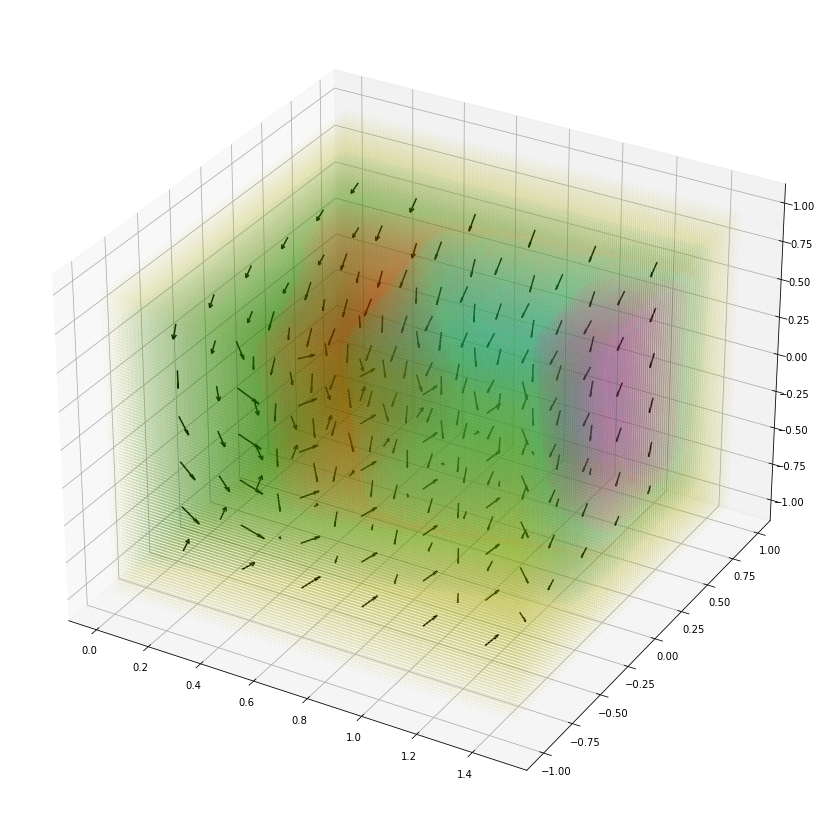

In [5]:
U = -np.log(rho)
colors = np.array(['m' for i in range(Nz) for j in range(Nxi) for k in range(Nz)])
colors[U.reshape(Np*Nxi*Nz) > 1.47] = 'c'
colors[U.reshape(Np*Nxi*Nz) > 1.49] = 'r'
colors[U.reshape(Np*Nxi*Nz) > 1.495] = 'g'
colors[U.reshape(Np*Nxi*Nz) > 1.7] = 'y'

p = p.reshape(Np*Nxi*Nz)
xi = xi.reshape(Np*Nxi*Nz)
z = z.reshape(Np*Nxi*Nz)

ax = plt.figure(figsize=(20,15)).add_subplot(projection='3d')
ax.scatter(p, xi, z, c=colors, alpha=0.05, s=1)
ax.quiver(p_,xi_,z_,J[0],J[1],J[2],length=0.1,normalize=True,color='k')
plt.show()

In [47]:
def path(x0,xf):
    Np = 100
    Nxi = 100
    Nz = 100
    Lp = 1.5 # p in [0,1.5]
    Lxi = 2 # xi in [-1,1]
    Lz = 2 # z in [-1,1]
    dp = Lp/Np
    dxi = Lxi/Nxi
    dz = Lz/Nz
    dx = np.array([dp,dxi,dz])
    
    path = []
    x = np.zeros(3)
    x = dx*np.round(x0/dx)
    xf = dx*np.round(xf/dx)
    while np.linalg.norm(x-xf) > 1e-5:
        path.append(x)
        v = xf-x
        mask = (np.abs(v)!=np.abs(v).max())
        v[mask] = 0
        v = np.sign(v)
        v = v*dx
        x = x+v
    return path
    

In [48]:
def action(path):
    Np = 100
    Nxi = 100
    Nz = 100
    Lp = 1.5 # p in [0,1.5]
    Lxi = 2 # xi in [-1,1]
    Lz = 2 # z in [-1,1]
    dp = Lp/Np
    dxi = Lxi/Nxi
    dz = Lz/Nz
    
    omega = 100
    k = 1
    f = 0.1*k
    h0 = 2*k
    g_m1m1 = 0     *k
    g_m10 = 0      *k
    g_m11 = 0.2    *k
    g_1m1 = 0      *k
    g_10 = 0.2     *k
    g_11 = 1.0     *k
    r_10 = 1.      *k
    r_01 = 1.      *k
    r_0m1 = 1.     *k
    r_m10 = 1.     *k
    dr_10 = 1.     *k
    dr_01 = 0      *k
    dr_0m1 = 1.    *k
    dr_m10 = 0     *k
    
    integral = 0
    for i in range(len(path)-1):
        p = path[i,0]
        xi = path[i,1]
        z = path[i,2]
        
        z_c = (1+z)/2
        z_s = (1-z)/2
        xi_c = (1+xi)/2
        xi_s = (1-xi)/2
        r_10 = r_10 + xi_c*dr_10
        r_0m1 = r_0m1 + xi_c*dr_0m1
        r_m10 = r_m10 + xi_c*dr_m10
        r_01 = r_01 + xi_c*dr_01
        fp = (xi_c*(g_11*z_c**2 + 2*g_10*z_c*z_s + g_1m1*z_s**2) +
              xi_s*(g_m11*z_c**2 + 2*g_m10*z_c*z_s + g_m1m1*z_s**2))
        fs = 2*(r_10 + xi_c*dr_10)*z_c*z_s + (r_0m1 + xi_c*dr_0m1)*z_s**2
        fc = 2*(r_m10 + xi_c*dr_m10)*z_c*z_s + (r_01 + xi_c*dr_01)*z_c**2
        
        dx = path[i+1,:]-path[i,:]
        dt = np.sqrt(np.sum(dx**2))
        dL_p = dx[0]*omega + (k*omega*p-omega*fp)*dt
        dL_xi = 0.5*dx[1] + (f*xi_c - h0*p**2*xi_s)*dt
        dL_z = dx[2] + (fc-fs)*dt
        
        integral = integral -dL_p-dL_xi-dL_z
        
    return integral
    

In [67]:
def minimize(x0,xf):
    l = np.array(path(x0,xf))
    path_min = l
    Smin = action(l)
    main = (xf-x0)/np.linalg.norm(xf-x0)
    
    count = 0
    while count < 100000:
        n = int(abs(np.random.randn()*100))+1
        start = np.sort(np.random.rand(n)*(len(l)-4))+2
        middle = np.random.randn(n,3)*0.2
        for i in range(n):
            middle[i] = middle[i] - np.dot(middle[i],main)
            middle[i] = middle[i]+l[int(start[i])]
        middle = np.delete(middle,(middle[:,0]<0),axis=0)
        middle = np.delete(middle,(middle[:,0]>1.5),axis=0)
        middle = np.delete(middle,(middle[:,1]<-1),axis=0)
        middle = np.delete(middle,(middle[:,1]>1),axis=0)
        middle = np.delete(middle,(middle[:,2]<-1),axis=0) 
        middle = np.delete(middle,(middle[:,2]>1),axis=0)
        if np.all(middle == 0):
            continue
    
        l = np.array(path(x0,middle[0]))
        if len(np.shape(l))==1:
            middle = np.delete(middle,0,axis=0)
            if np.all(middle == 0):
                continue
            l = np.array(path(x0,middle[0]))
        n = np.shape(middle)[0]
        for i in range(1,n):
            temp = np.array(path(middle[i-1],middle[i]))
            if len(np.shape(temp))==1:
                continue
            l = np.concatenate((l,temp))
        temp = np.array(path(middle[n-1,:],xf))
        if len(np.shape(temp))==2:
            l = np.concatenate((l,temp))
    
        S = action(l)
        
        if S < Smin:
            path_min = l
            Smin = S
        else:
            count += 1
            
    return Smin, path_min

In [ ]:
x0 = np.array([0.1,-0.9,-0.9])
xf = np.array([1.5,0.9,0.9])

_, forward = minimize(x0,xf)
_, back = minimize(xf,x0)
   

In [ ]:
np.save('forward.npy',forward)
np.save('back.npy',back)

In [3]:
fo = np.load('forward.npy')
ba = np.load('back.npy')

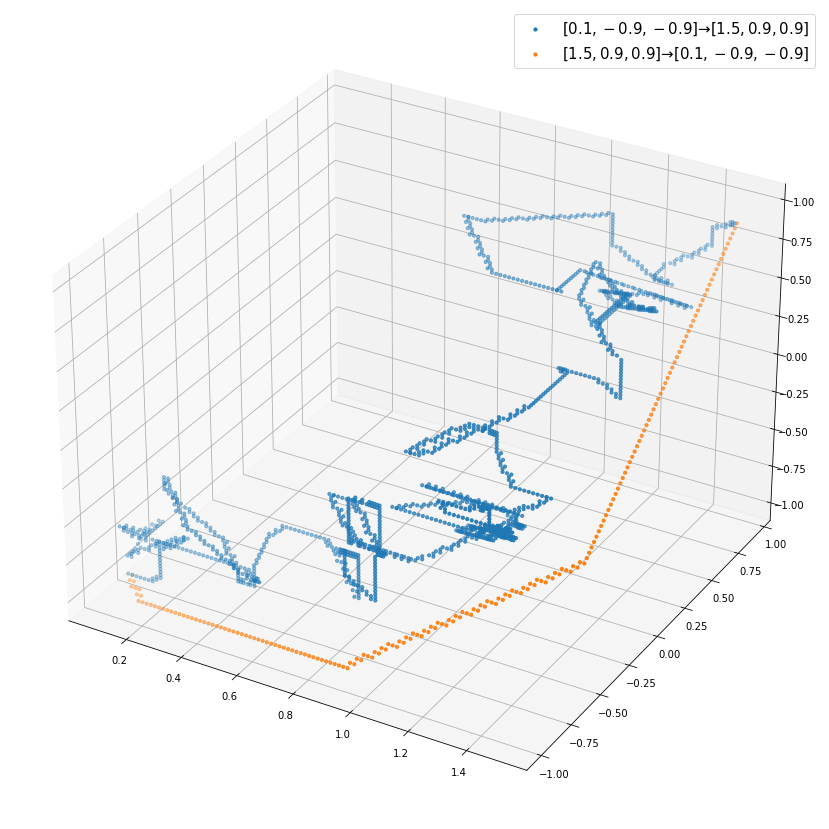

In [10]:
ax = plt.figure(figsize=(20,15)).add_subplot(projection='3d')
ax.scatter(fo[:,0], fo[:,1], fo[:,2], s=10, label=r'$[0.1,-0.9,-0.9]\to[1.5,0.9,0.9]$')
ax.scatter(ba[:,0], ba[:,1], ba[:,2], s=10, label=r'$[1.5,0.9,0.9]\to[0.1,-0.9,-0.9]$')
plt.legend(fontsize=15)
plt.show()